## Efficient Frontier

**Joshua and Jingwen**

The Efficient Frontier represents the set of optimal portfolios offering the highest expected return for a given level of risk. It is derived by analyzing different portfolio combinations and plotting risk (measured by standard deviation) against expected return. Any portfolio below the frontier is suboptimal, as higher returns could be achieved for the same risk level.

### Initialization

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

In [70]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .drop(columns=['btc', 'eth']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")

data

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,link,ltc,sol
date,,,,,,,,,,,,,,,,,,,,,
2024-03-15,146.463730,171.808746,171.628006,160.639999,113.183418,87.368553,370.019684,492.459991,192.012970,57.146446,...,50.184948,107.636833,125.857620,134.207184,124.102211,285.859985,170.748978,7.580000,30.155153,1.84
2024-03-18,145.083298,172.903580,172.216553,161.860001,110.194344,86.912125,368.113281,513.859985,188.097961,58.206318,...,50.233215,108.633209,126.075172,133.648148,124.885483,285.970001,168.888824,7.380000,30.211365,1.81
2024-03-19,146.374374,175.252502,173.345444,161.789993,110.899956,87.168869,373.457123,521.190002,187.429062,58.803699,...,50.609673,109.397408,127.024521,134.648529,125.579514,285.190002,171.134842,7.486667,30.408087,1.81
2024-03-20,146.265106,177.830292,170.074600,164.710007,109.273117,87.701378,375.788269,519.140015,191.147369,59.073486,...,50.754463,109.300674,127.281654,133.883530,125.450615,285.809998,169.185654,7.480000,30.700203,1.95
2024-03-21,147.715057,170.564621,171.261353,168.179993,109.282906,86.236992,340.811249,511.250000,191.963791,60.191174,...,50.484180,109.784340,128.547440,133.942398,125.986008,295.059998,166.543823,7.580667,30.982893,1.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,121.900002,227.479996,216.660004,132.149994,137.360001,90.720001,335.299988,435.079987,216.259995,50.610001,...,68.774353,111.800003,128.250000,158.089996,110.650002,283.359985,171.800003,5.500000,36.139999,1.44
2025-03-11,121.029999,220.839996,213.589996,125.440002,132.660004,90.089996,327.790009,433.660004,209.080002,48.639999,...,68.159508,109.160004,123.629997,156.699997,107.339996,280.329987,164.389999,5.510000,35.730000,1.40
2025-03-12,119.849998,216.979996,212.059998,126.550003,130.279999,89.160004,324.329987,438.600006,206.619995,47.080002,...,68.278503,109.129997,122.849998,154.399994,104.029999,279.179993,161.679993,5.690000,35.270000,1.39


In [71]:
# Check for NA values in the DataFrame
na_check = data.isna().sum()
print("NA values in each column:\n", na_check[na_check > 0])

NA values in each column:
 Series([], dtype: int64)


In [72]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

In [46]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 79.8%
Annual volatility: 10.3%
Sharpe Ratio: 7.74


c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(np.float64(0.7979028078984564),
 np.float64(0.10313580421336706),
 np.float64(7.7364288181411505))

Expected annual return: 272.9%
Annual volatility: 63.2%
Sharpe Ratio: 4.32
(np.float64(2.7291946121841915), np.float64(0.6318200574298255), np.float64(4.319575771757318))


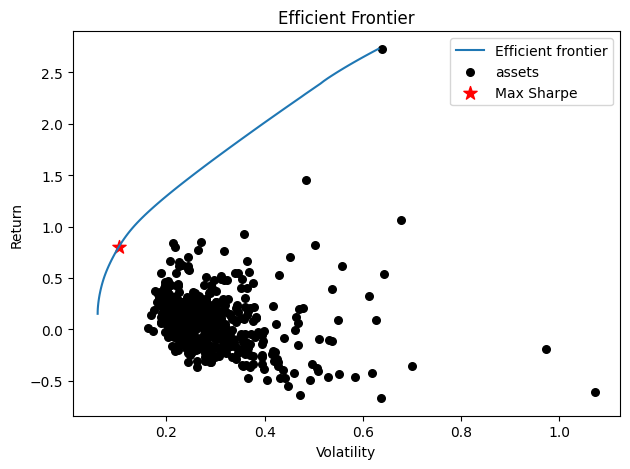

In [ ]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S)

# Generate plot
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Log performance
print(ef.portfolio_performance(verbose=True))

# Output
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [87]:
weights = ef_max_sharpe.clean_weights()

{e[0]: e[1] for e in sorted(list(weights.items()), key=lambda x: -x[1]) if e[1] > 0}


{'K': 0.16039,
 'PM': 0.10121,
 'FOX': 0.0822,
 'GILD': 0.06787,
 'PLTR': 0.06395,
 'T': 0.06248,
 'TPL': 0.05234,
 'TMUS': 0.05192,
 'FOXA': 0.0511,
 'WELL': 0.05064,
 'ETR': 0.04314,
 'TTWO': 0.04223,
 'MMM': 0.03476,
 'MO': 0.0299,
 'MCK': 0.02403,
 'RTX': 0.02117,
 'CBOE': 0.01478,
 'KDP': 0.01266,
 'AVGO': 0.0088,
 'VTR': 0.00569,
 'NVDA': 0.00353,
 'EQT': 0.00351,
 'GOOGL': 0.00313,
 'GRMN': 0.00187,
 'KMI': 0.00079}

In [88]:
mu
mu.sort_values()

MRNA   -0.671018
CE     -0.642312
SMCI   -0.609853
EL     -0.550066
DLTR   -0.497463
          ...   
TRGP    0.845889
HWM     0.930633
VST     1.059809
TPL     1.450006
PLTR    2.729330
Length: 501, dtype: float64

Palantir's returns are crazy lmao